# __Predicting Extreme Poverty on a country-scale__

In [12]:
import pandas as pd 
import warnings
#import plots as plot
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
import category_encoders as ec
from sklearn import preprocessing
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier

warnings.filterwarnings('ignore')

# TODO - DELETE THIS FOR SUBMISSION
Which dataset(s) did you choose? Why? How did you clean/transform the data? Why? How did you solve the
problem of missing values? Why? What questions did you ask of the data? Why were these
good questions? What were the answers to these questions? How did you obtain them? Do
the answers make sense? Were there any difficulties in analysing the data? What were the
key insights obtained? Which Data Science tools and techniques were learned during this
exercise? How was the work divided up between the members of the group

## Index
1. Data Exploration and Data Preparation
    * 1.1 Data Transformation
    * 1.2 Target Column
    * 1.3 Feature Overview
    * 1.4 Data Imputation
    * 1.5 Data Vizualization & Exploration
2. Answering the 3 Questions
    * 2.1 What percentage of the world population lives in extreme poverty?
    * 2.2 Which characteristics are predictive for countries with large populations living in extreme poverty?
    * 2.3 Which characteristics are predictive for populations emerging from extreme poverty?
3. Conclusions
    * 3.1 Comparing Q1 and Q2

# 1 Data Exploration and Data Preparation

## The Data Set

TODO: Explain this

## 1.1 Data Transformation

In [13]:
# READ SOURCE CSV
raw = pd.read_csv("unesco_poverty_dataset.csv") 
keys = raw.DEMO_IND.unique() 

# DEFINE BASE CSV
base = raw[['LOCATION', 'TIME']]

# FOR EVERY VAR JOIN ON LOCATION & TIME 
for i in range(0,len(keys)):
    loop = raw.loc[raw.DEMO_IND == keys[i]]
    base = pd.merge(base, loop[['LOCATION', 'TIME', 'Value']],  how='left', left_on=['LOCATION','TIME'], right_on = ['LOCATION','TIME']) 
    base.columns = base.columns.str.replace('Value', keys[i])

# DROP DUPLICATES
base = base.drop_duplicates()

## 1.2 Target Column
_what is the target column supposed to be?_    
There are 3 different metrics to count the GNI of a state: __LCU, Atlas, PPP__, so which is the correct one?   

The Poverty Threshold changed throughout the years: 
* 1/day in 1996 (measure unknown)   
* 1.25/day in 2005 (measure unknown, presumably Atlas)   
* 1.9/day in 2015 (PPP)   
_the $ values being average per capita income of a person per day_   

[World Bank Press Release, October 2015]('https://www.worldbank.org/en/news/press-release/2015/10/04/world-bank-forecasts-global-poverty-to-fall-below-10-for-first-time-major-hurdles-remain-in-goal-to-end-poverty-by-2030')

In [14]:
# SEPARATE INTO 3 SUB-TABLES: 1970-2004, 2005-2014, 2015-2019
sub_0 = base[base['TIME'] < 2005]
sub_1 = base[(base['TIME'] >= 2005) & (base['TIME'] < 2015)]
sub_2 = base[base['TIME'] >= 2015]

# WRITE TARGET VARIABLES
sub_0['poverty'] = base['NY_GNP_PCAP_CN'].apply(lambda x: (x / 365) < 1)
sub_1['poverty'] = base['NY_GNP_PCAP_CD'].apply(lambda x: (x / 365) < 1.25)
sub_2['poverty'] = base['NY_GNP_PCAP_PP_CD'].apply(lambda x: (x / 365) < 1.9)

# RE-CONCAT SUB-DATAFRAMES
base = pd.concat([sub_0, sub_1, sub_2])

# SHOW HOW MANY COUNTRIES WERE POOR AT LEAST ONCE
poor = base[base['poverty'] == True]
perc_poor_countries_ever = round(poor['LOCATION'].drop_duplicates().shape[0] / base['LOCATION'].drop_duplicates().shape[0] * 100,2)

print('From 1970-2019, all countries considered,', perc_poor_countries_ever, '% have lived in extreme poverty at least once.')

From 1970-2019, all countries considered, 29.61 % have lived in extreme poverty at least once.


## 1.3 Features

In [15]:
# GET DATA PER COLUMN
na_percent = []
na_total = []
minimum = []
maximum = []
for col in base.columns:
    na_percent.append(round(base[col].isna().sum() / base.shape[0] * 100, 2))
    na_total.append(base[col].isna().sum())
    minimum.append(base[col].min())
    maximum.append(base[col].max())

# GET VARIABLE DESCRIPTIONS
descriptions = raw['Indicator'].drop_duplicates().tolist()
descriptions.insert(0, 'LOCATION')
descriptions.insert(1, 'TIME')
descriptions.insert(38, 'poverty')

features = pd.DataFrame(
    {'descriptions': descriptions, 
    'na_percent': na_percent, 
    'na_total': na_total,
    'minimum': minimum,
    'maximum': maximum},
    index=base.columns) 

features

,descriptions,na_percent,na_total,minimum,maximum
LOCATION,LOCATION,0.00,0,ABW,ZZA
TIME,TIME,0.00,0,1970,2019
SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",19.16,2231,0.827,8.866
SP_DYN_LE00_IN,"Life expectancy at birth, total (years)",19.30,2247,18.907,85.4171
SP_DYN_IMRT_IN,"Mortality rate, infant (per 1,000 live births)",24.68,2873,1.6,218.7
SP_POP_GROW,Population growth (annual %),11.74,1367,-9.08064,19.5973
SH_DYN_AIDS_ZS,"Prevalence of HIV, total (% of population ages...",67.29,7834,0.1,28.4
SP_RUR_TOTL_ZS,Rural population (% of total population),15.17,1766,0.02,97.155
NY_GDP_MKTP_CN,GDP (current LCU),23.53,2739,0.00815,1.53165e+16
NY_GDP_MKTP_CD,GDP (current US$),28.35,3301,8.82445e+06,1.94854e+13


## 1.4 Data Imputation

In [16]:
# READ TRANSFORMED CSV FILE
raw = pd.read_csv("transformed.csv")  
feature_descriptions = pd.read_csv("feature_descriptions.csv")

# FEATURES WITH LESS THAN 50% MISSING VALUES
features = feature_descriptions.where(feature_descriptions['na_percent']<=50.0).dropna(0)

# ONLY DEMOGRAFIC FEATURES!
#cols_to_drop = 7:13 + 18:25
cols = features['Unnamed: 0'].tolist()
cols = cols[0:7]+ cols[13:18] + [cols[25]]
dataset = raw[cols]
    
by_country = dataset.groupby(by=dataset['LOCATION'])  
dataset_full = pd.DataFrame(columns=cols)
dataset_full2 = pd.DataFrame(columns=cols)


for name, group in by_country :
    tdf = pd.DataFrame(columns=cols)
    tdf2 = pd.DataFrame(columns=cols) 

    tdf['TIME'] = group['TIME']
    tdf['poverty'] = group['poverty']

    # cols with all NaN values
    all_null = group.isna().all()  
    null_cols = all_null.where(all_null == 1).dropna(0).index.tolist()
    tdf[null_cols] = 0

    # cols for interpolation
    cols_to_int = all_null.where(all_null == 0).dropna(0).index.tolist()[2:]
    cols_to_int.remove('poverty')

    tdf[cols_to_int] = group[cols_to_int].interpolate(method='linear', axis=0)
    tdf['LOCATION'] = name 

    # fill the NaN values that were not interpolated
    tdf.fillna(tdf.mean(), inplace=True)

    # Another way to interpolate - take mean for the cols with all NaNs
    tdf2 = group.interpolate(method ='linear', limit_direction ='forward', axis = 0)
    tdf2 = tdf2.interpolate(method ='linear', limit_direction ='backward', axis = 0)
    tdf2['LOCATION'] = name
    tdf2.fillna(dataset.drop(labels=['LOCATION'], axis=1).mean(), inplace=True)
    dataset_full2 = pd.concat([dataset_full2,tdf2])
    
    dataset_full = pd.concat([dataset_full,tdf])

# NA -> mean    
dataset_full2.sort_index(inplace=True)
# NA -> 0
dataset_full.sort_index(inplace=True)

# dataset_full2.head(100)

## 1.5 Visualizations & Data Exploration

In [17]:
pass

# 2 Answering the Questions

## 2.1 - What percentage of the world population lives in extreme poverty?

In [18]:
def question1(base):
    poverty_percent = {'TIME': [], 'PERCENT': []}
    for i in range(1970, 2017):
        poverty_percent['TIME'].append(i)
        poverty_percent['PERCENT'].append(base[(base['TIME']==i) & (base['poverty'])].shape[0] / base[base['TIME']==i].shape[0])

    pp = pd.DataFrame(poverty_percent)

    fig = px.line(
        pp, 
        x='TIME', 
        y='PERCENT', 
    )
    return fig

question1(dataset_full2)

## 2.2 Which characteristics are predictive for countries with large populations living in extreme poverty?

### Training the model

In [19]:
# GROUND TRUTH AS NUMERIC
y = dataset_full['poverty']
y = y.apply(lambda x: 1 if x==True else 0)
X_2 = dataset_full2.drop(labels=['LOCATION', 'poverty'], axis=1)

# FUNCTIONS FOR ML 
def print_performance (classifier, X, y, scores= ['accuracy', 'precision', 'recall'], model=''):
    for score in scores:
        cv2 = cross_val_score(classifier, X, y, cv=10, scoring=score)
        cv2_m = cv2.mean()
        cv2_sd = cv2.std()
        print(model + ' ' + score +" : " + str(round(cv2_m, 5))+ ' +- '+ str(round(cv2_sd, 5)))

def r_classifier (X, y, alpha=1.0, fit_intercept=True, normalize=True, solver='auto', max_iter=1000, tol=0.0001) :
    reg = linear_model.RidgeClassifier(alpha=alpha, fit_intercept=fit_intercept, normalize=normalize, max_iter=max_iter, tol=0.001, solver='auto', random_state=30)
    print_performance(reg, X , y, model='Ridge Calssifier', scores= ['accuracy'])
    reg.fit(X,y)
    return reg   

ridge_2 =  r_classifier(X_2,y, alpha=0.1)

Ridge Calssifier accuracy : 0.94262 +- 0.00032


### Finding the most predictive features

In [20]:
R2_coef = np.array(ridge_2.coef_)
X2_cols = X_2.columns
R2_relativ = np.abs(R2_coef)/np.abs(R2_coef).sum()
table = {'col':X2_cols, 'absolute':[], 'relative':[]}

# Fill into Dataframe
for i in range(0,len(X2_cols)):
    table['absolute'].append(round(R2_coef[0,i],6))
    table['relative'].append(round(R2_relativ[0,i],6))
    
q2_weights = pd.DataFrame.from_dict(table)
q2_weights

,col,absolute,relative
0,TIME,-0.001943,0.075534
1,SP_DYN_TFRT_IN,0.012889,0.501145
2,SP_DYN_LE00_IN,-0.003791,0.147391
3,SP_DYN_IMRT_IN,0.000964,0.037497
4,SP_POP_GROW,-0.005550,0.215784
5,SP_RUR_TOTL_ZS,-0.000580,0.022568
6,200101,0.000000,0.000000
7,200151,0.000001,0.000032
8,200345,-0.000000,0.000010
9,200343,0.000001,0.000028


## 2.3 - Which characteristics are predictive for populations emerging from extreme poverty?

### Identifying emerging countries

In [22]:
def just_demographic(df_poor):
    feature_descriptions = pd.read_csv("../feature_descriptions.csv")

    #FEATURES WITH LESS THAN 50% MISSING VALUES
    features = feature_descriptions.where(feature_descriptions['na_percent']<=50.0).dropna(0)
    
    #ONLY DEMOGRAFIC FEATURES!
    cols = features['Unnamed: 0'].tolist()
    cols = cols[0:7]+ cols[13:18] + [cols[25]]
    df_poor = df_poor[cols]
    return (df_poor)

def interpolation_df_poor(df_poor):
    columns = df_poor.columns
    countries = df_poor['LOCATION'].unique()
    for c in countries:
        df_c = df_poor[df_poor['LOCATION']==c]
        df_c = df_c.interpolate(method ='linear', 
                                    limit_direction ='forward',
                                    axis = 0)
        df_c = df_c.interpolate(method ='linear', 
                                    limit_direction ='backward',
                                    axis = 0)
        df_c.fillna(poor.drop(labels='LOCATION', axis=1).mean(), inplace =True)
        df_poor[df_poor['LOCATION']==c] = df_c
    return(df_poor)

# READ FROM DATA_PREP
df_p = pd.read_csv("../transformed.csv")
poor = df_p
poor = just_demographic(poor)
poor = interpolation_df_poor(poor)

# Identifying emerging countries from poverty
# Poor countries
p_poor = poor[poor['poverty'] == 1]
c_poor = p_poor.LOCATION.unique() # poor countries

# No Poor countries
no_poor = poor[(poor['poverty'] == 0) & (poor['TIME'] == 2015)]
# no_poor = no_poor[poor['TIME'] == 2015]
c_no_poor = no_poor.LOCATION.unique() # no poor countries 2015
e_countries = set(c_no_poor).intersection(c_poor) # Identifying emerging countries
# e_countries = Emerging
poor['emerging'] = poor['LOCATION'].isin(e_countries)
e_poor = poor[poor['LOCATION'].isin(e_countries)]

### Identifying emerging countries

In [59]:
#import streamlit as st
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.tree import _tree
from sklearn.tree import DecisionTreeClassifier as DTC

def just_demographic(df_poor):
    feature_descriptions = pd.read_csv("feature_descriptions.csv")

    #FEATURES WITH LESS THAN 50% MISSING VALUES
    features = feature_descriptions.where(feature_descriptions['na_percent']<=50.0).dropna(0)
    
    #ONLY DEMOGRAFIC FEATURES!
    cols = features['Unnamed: 0'].tolist()
    cols = cols[0:7]+ cols[13:18] + [cols[25]]
    df_poor = df_poor[cols]
    return (df_poor)

def alles_good_papi():
    return("Alles good papi")

def interpolation_df_poor(df_poor):
    columns = df_poor.columns
    countries = df_poor['LOCATION'].unique()
    for c in countries:
        df_c = df_poor[df_poor['LOCATION']==c]
        df_c = df_c.interpolate(method ='linear', 
                                    limit_direction ='forward',
                                    axis = 0)
        df_c = df_c.interpolate(method ='linear', 
                                    limit_direction ='backward',
                                    axis = 0)
        df_c.fillna(poor.drop(labels='LOCATION', axis=1).mean(), inplace =True)
        df_poor[df_poor['LOCATION']==c] = df_c
    return(df_poor)

def thresholds(df_poor):
    poor = df_poor
    thresholds = {}
    columns = poor.columns[2:-2]
    #st.write(columns)
    X = poor.iloc[:,2:-2]
    #st.write(len(X))
    #st.write(columns)
    y = poor.iloc[:,-2:-1]
    #st.write(len(y))
    #st.write(y)
    for c in columns:
        #st.write(c)
        #st.write(X[c])
        X_ = np.array(X[c]).reshape(-1, 1)#X.iloc[:,c]
        clf_tree = DTC(criterion="gini",
                        max_depth=1, 
                        splitter="best")
        clf_tree.fit(X_,y)
        #thresholds[c] = clf_tree.tree_.threshold[0]
        threshold = clf_tree.tree_.threshold[0]
        #st.write(X_.mean())
        #st.write(threshold)
        #break        
        thresholds[c] = threshold    
    return(thresholds)


def e_poor_selectKBest(df_e_poor, score_f = f_classif, k='all'):
    e_poor = df_e_poor
    # Split dataset to train
    X = e_poor.iloc[:,2:-2] # All the columns less the last one
    y = e_poor.iloc[:,-2:-1] # Just the last column
    dfcolumns = pd.DataFrame(X.columns)

    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    # Create the feature selector
    #perhaps a switch
    bestFeatures = SelectKBest(score_func=score_f, k=k)
    fit = bestFeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)

    # Create a data frame to see the impact of the features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Scores']
    featureScores.sort_values(by='Scores', ascending=False, inplace=True)
    scores = featureScores.Scores
    rel_scores = np.array(scores)/np.abs(np.array(scores)).sum()
    rel_scores.reshape(-1, 1)
    #st.write(rel_scores.shape)

    rel_scores = pd.DataFrame(rel_scores, dtype=float, columns=['Relative'])

    df_scores = pd.concat([featureScores,rel_scores], axis=1)
    #st.write(df_scores)
    #st.write(scores)
    #st.write(rel_scores)
    return(df_scores)

def e_poor_feature_importance(df_e_poor):
    e_poor = df_e_poor
    # Split dataset to train
    X = e_poor.iloc[:,2:-2] # All the columns less the last one
    y = e_poor.iloc[:,-2:-1] # Just the last column
    model = ExtraTreesClassifier()
    model.fit(X,y)
    print(model.feature_importances_)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    #st.write(feat_importances)

    #columns = pd.DataFrame(feat_importances.index)
    #st.write(columns)
    scores = pd.DataFrame(feat_importances, dtype=float)
    featureScores = scores.reset_index()
    featureScores.columns = ['Features','Scores']
    df_scores0 = featureScores.sort_values(by='Scores', ascending=False)
    df_scores0.reset_index(drop=True, inplace=True)
    #st.write(featureScores)
    scores = df_scores0.Scores
    rel_scores = np.array(scores)/np.abs(np.array(scores)).sum()
    rel_scores.reshape(-1, 1)
    #st.write(rel_scores.shape)
    rel_scores = pd.DataFrame(rel_scores, dtype=float, columns=['Relative'])
    df_scores = pd.concat([df_scores0,rel_scores], axis=1)
    #st.write(df_scores)
    print(df_scores)
    # Plot it in a barchart
    feat_importances.nlargest(20).plot(kind='barh', figsize = (13, 6), fontsize=12)
    #st.pyplot()
    plt.show()
    return("All fertig pa pitura")


def plot_correlation_matrix(df_e_poor, n=20):
    data = e_poor.iloc[:,2:-2] # All features
    # Split dataset to train
    columns = data.columns
    plt.clf()
    correlation = data.corr()
    #columns = correlation.nlargest(n, 'poverty').index
    #st.write('OK')
    #st.write(columns)
    #st.write(data[columns].values)

    correlation_map = np.corrcoef(data[columns].values.T)
    sns.set(font_scale=1, rc={'figure.figsize':(30,30)})
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=False, 
                            square=True, fmt='.2f', yticklabels=columns.values, 
                            xticklabels=columns.values)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation = 90, fontsize = 16)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation = 0, fontsize = 16)
    plt.show()
    #st.pyplot()
    return("All fertig pa pitura")

### Read data for question 3

In [60]:
df_p = pd.read_csv("transformed.csv")
poor = df_p
poor = just_demographic(poor)
poor = interpolation_df_poor(poor)
print (poor.head(6))
print (poor.shape)

  LOCATION  TIME  SP_DYN_TFRT_IN  SP_DYN_LE00_IN  SP_DYN_IMRT_IN  SP_POP_GROW  \
0      AUS  1970           2.859        71.01854            17.8      1.97019   
1      AUS  1971           2.961        71.06829            17.4      3.38029   
2      AUS  1972           2.744        71.45756            16.8      1.83815   
3      AUS  1973           2.491        71.84683            16.1      1.52882   
4      AUS  1974           2.397        72.23610            15.3      2.53122   
5      AUS  1975           2.148        72.62537            14.4      1.23119   

   SP_RUR_TOTL_ZS     200101    200151    200345    200343    200144  poverty  
0          16.001  12793.034  1054.644  5767.311  3729.907  2241.172    False  
1          15.840  13033.133  1087.712  5893.591  3763.468  2288.362    False  
2          15.680  13244.171  1118.063  6017.034  3787.515  2321.559    False  
3          15.522  13431.794  1147.129  6138.482  3801.483  2344.700    False  
4          15.364  13605.570  11

### Identifying emerging countries from poverty

In [61]:
p_poor = poor[poor['poverty'] == 1]
c_poor = p_poor.LOCATION.unique() # poor countries

# No Poor countries
no_poor = poor[(poor['poverty'] == 0) & (poor['TIME'] == 2015)]
#no_poor = no_poor[poor['TIME'] == 2015]
c_no_poor = no_poor.LOCATION.unique() # no poor countries 2015
e_countries = set(c_no_poor).intersection(c_poor) # Identifying emerging countries
#e_countries # Emerging
poor['emerging'] = poor['LOCATION'].isin(e_countries)
e_poor = poor[poor['LOCATION'].isin(e_countries)]
#st.write(poor)
thresholds(df_poor=poor)
print(e_poor.head(6))
print('From a total of',len(poor.LOCATION.unique()),'countries,', len(e_countries), 'have emerged from extreme poverty')

    LOCATION  TIME  SP_DYN_TFRT_IN  SP_DYN_LE00_IN  SP_DYN_IMRT_IN  \
315      GRC  1970            2.40        70.90363            27.6   
316      GRC  1971            2.32        71.22656            25.9   
317      GRC  1972            2.32        71.53500            24.9   
318      GRC  1973            2.27        71.81485            24.4   
319      GRC  1974            2.38        72.06463            24.0   
320      GRC  1975            2.33        72.29371            23.3   

     SP_POP_GROW  SP_RUR_TOTL_ZS    200101    200151    200345    200343  \
315      0.22820          35.780  8663.571   881.841  4211.048  2258.641   
316      0.43384          35.049  8716.873   911.695  4209.690  2266.369   
317      0.65004          34.546  8774.514   943.322  4225.466  2260.807   
318      0.45413          34.048  8840.315   976.119  4254.487  2248.445   
319      0.36818          33.552  8919.244  1008.991  4289.365  2240.923   
320      0.93866          33.060  9014.085  1041.551 

In [62]:
print('From a total of',len(poor.LOCATION.unique()),'countries,', len(e_countries), 'have emerged from extreme poverty')

From a total of 233 countries, 68 have emerged from extreme poverty


### The emerging countries by year

In [63]:
def years_emerged(e_poor):
    years = {}
    years_total = {}
    e_countries = list()
    df_e_poor = e_poor
    for y in df_e_poor.TIME.unique():
        df_y = df_e_poor[df_e_poor['TIME'] == y]
        countries = list()
        #countries_total = list()
        for c in df_y.LOCATION.unique():
            df_c = df_y[df_y['LOCATION'] == c]
            if ((df_c.iloc[0,-2] == 0) & (c not in e_countries)):
                #st.write(df_c.iloc[0,-2])
                e_countries.append(c)
                countries.append(c)
            #break
        #st.write(y,countries)
        y = int(y)
        years[y] = countries
        years_total[y] = len(countries)
    # PLOT
    #sns.distplot(years, kde=False)
    plt.bar(years_total.keys(), years_total.values(), color='g')
    plt.show()
    #st.pyplot()
    return(years)

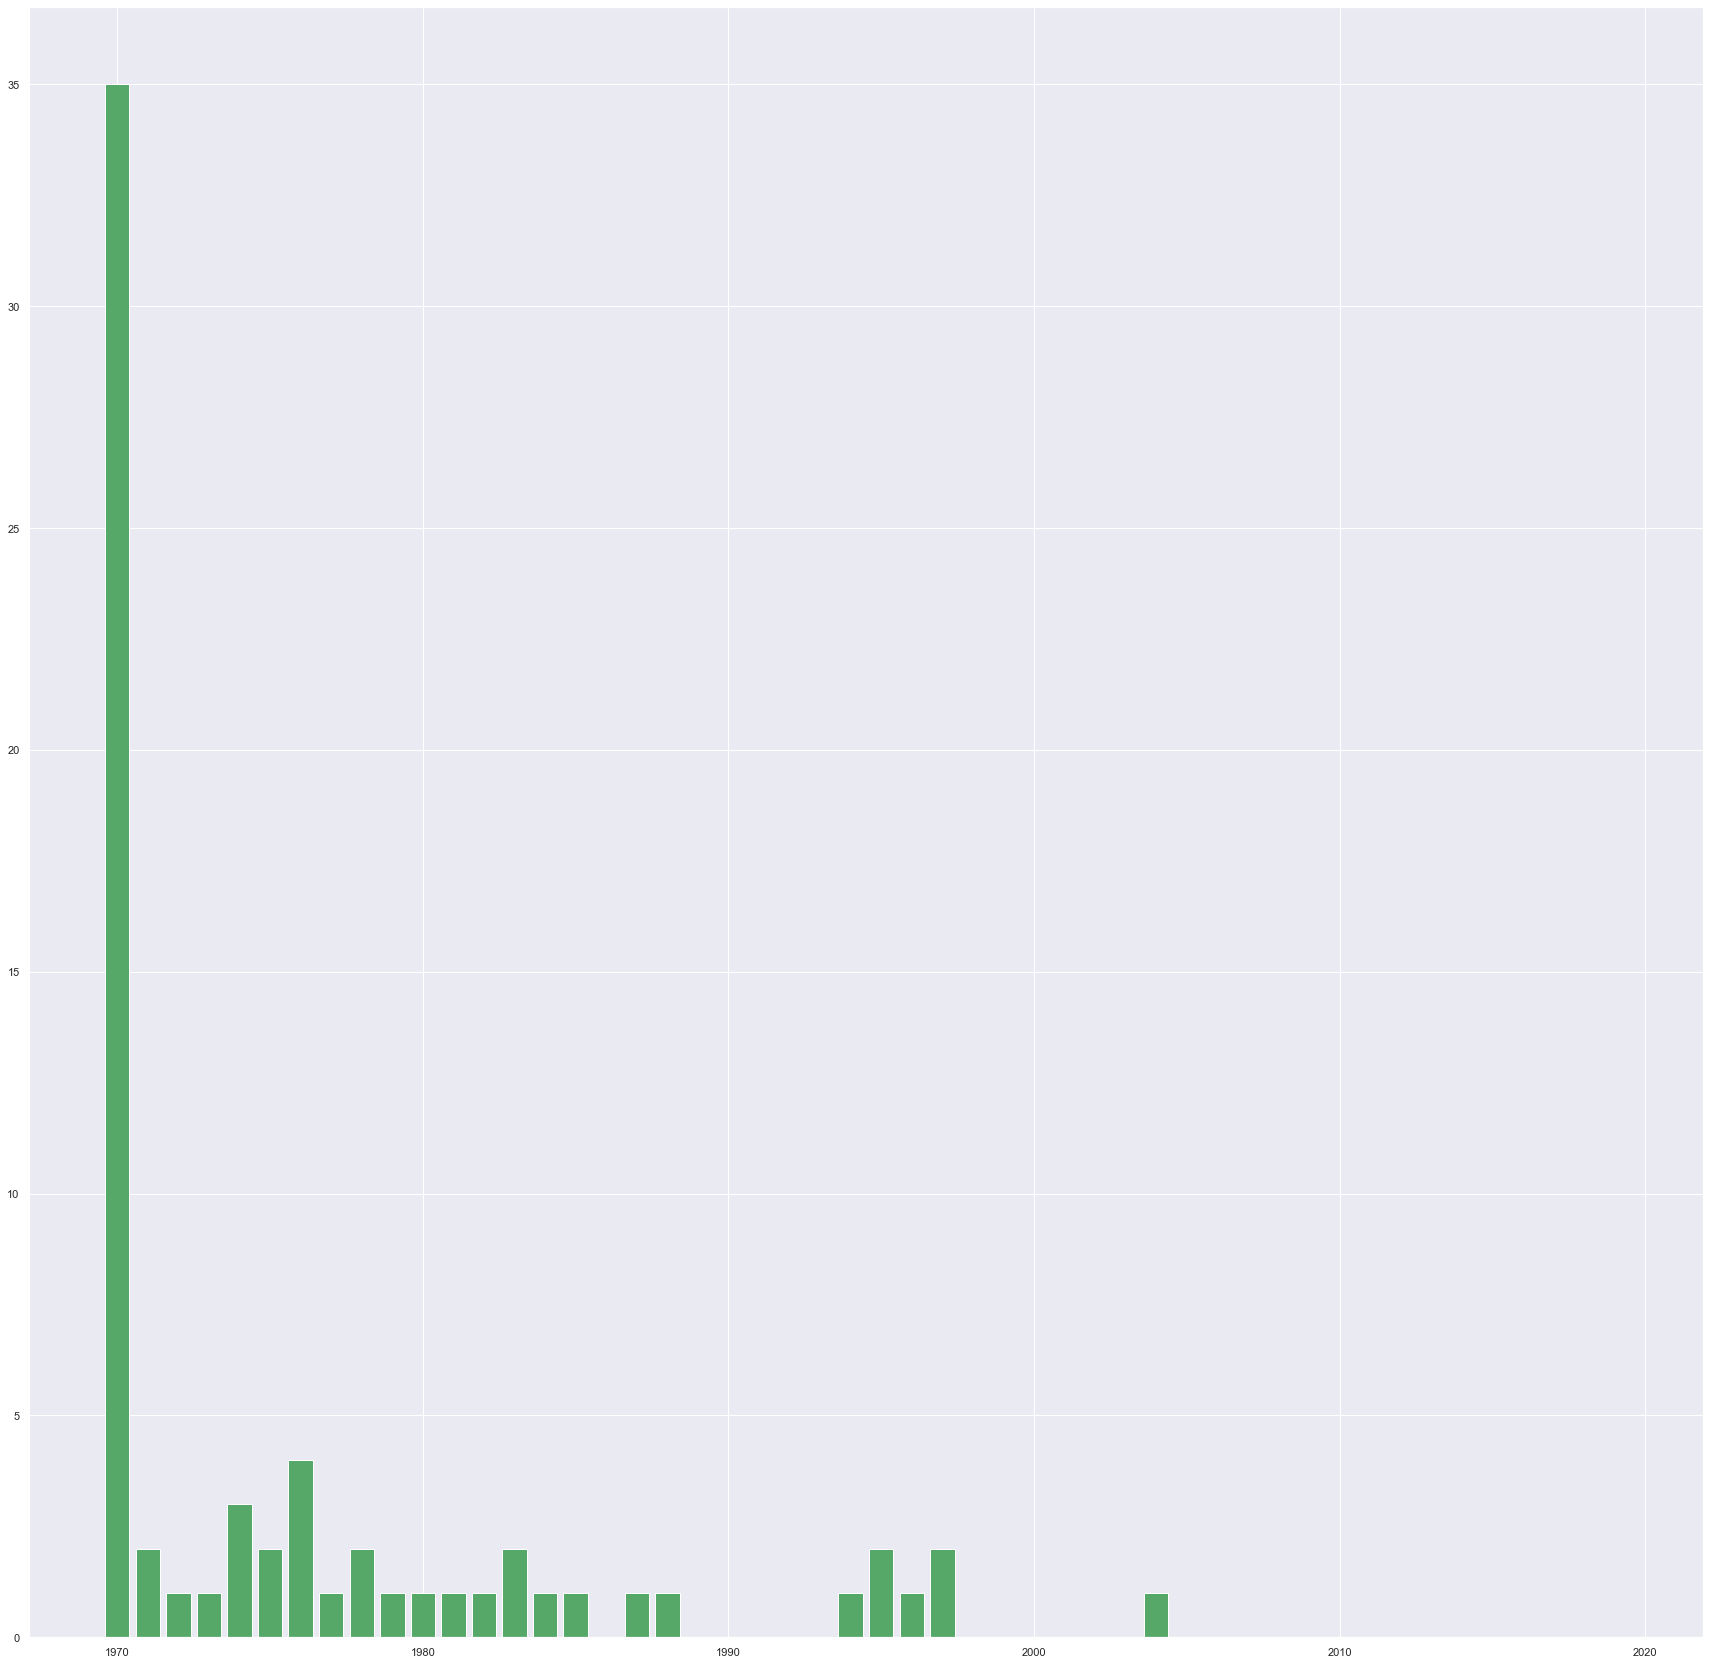

{1970: ['AFG',
  'AGO',
  'ARG',
  'ARM',
  'AZE',
  'BOL',
  'BRA',
  'BGR',
  'BFA',
  'BDI',
  'COD',
  'ERI',
  'ETH',
  'GEO',
  'GIN',
  'HTI',
  'KGZ',
  'LBR',
  'MKD',
  'MDG',
  'MOZ',
  'MMR',
  'NPL',
  'NIC',
  'NER',
  'PER',
  'RUS',
  'RWA',
  'SLB',
  'TGO',
  'UZB',
  'ROU',
  'TKM',
  'TJK',
  'BLR'],
 1971: ['FJI', 'ZWE'],
 1972: ['DOM'],
 1973: ['GTM'],
 1974: ['CHL', 'SLV', 'OMN'],
 1975: ['GMB', 'SWZ'],
 1976: ['GRC', 'BWA', 'NGA', 'PNG'],
 1977: ['PRT'],
 1978: ['CHN', 'TUN'],
 1979: ['JOR'],
 1980: ['LSO'],
 1981: ['SLE'],
 1982: ['EGY'],
 1983: ['ISR', 'UGA'],
 1984: ['MEX'],
 1985: ['GNB'],
 1986: [],
 1987: ['URY'],
 1988: ['MWI'],
 1989: [],
 1990: [],
 1991: [],
 1992: [],
 1993: [],
 1994: ['VEN'],
 1995: ['UKR', 'SUR'],
 1996: ['ZMB'],
 1997: ['SDN', 'TUR'],
 1998: [],
 1999: [],
 2000: [],
 2001: [],
 2002: [],
 2003: [],
 2004: ['GHA'],
 2005: [],
 2006: [],
 2007: [],
 2008: [],
 2009: [],
 2010: [],
 2011: [],
 2012: [],
 2013: [],
 2014: [],
 2015: 

In [65]:
years_emerged(e_poor)

### Best K features to characterize the emerging population

Execution of the K Best features
f_classif
         Features     Scores  Relative
0  SP_DYN_TFRT_IN  82.582937  0.298053
1  SP_DYN_LE00_IN  59.385197  0.288574
2  SP_DYN_IMRT_IN  79.956479  0.214329
3     SP_POP_GROW  26.239385  0.094702
4  SP_RUR_TOTL_ZS  11.908895  0.042981
5          200101   2.785567  0.024493
6          200151   6.786261  0.018796
7          200345   5.208026  0.010053
8          200343   0.050929  0.007834
9          200144   2.170714  0.000184
chi2
         Features     Scores  Relative
0  SP_DYN_TFRT_IN  12.438803  0.345544
1  SP_DYN_LE00_IN   3.586731  0.344627
2  SP_DYN_IMRT_IN  12.405808  0.099638
3     SP_POP_GROW   0.238912  0.056003
4  SP_RUR_TOTL_ZS   1.369938  0.054909
5          200101   1.107916  0.038056
6          200151   1.976598  0.030777
7          200345   2.015979  0.023309
8          200343   0.018032  0.006637
9          200144   0.839058  0.000501
mutual_info_classif
         Features    Scores  Relative
0  SP_DYN_TFRT_IN  0.016036  0.14389

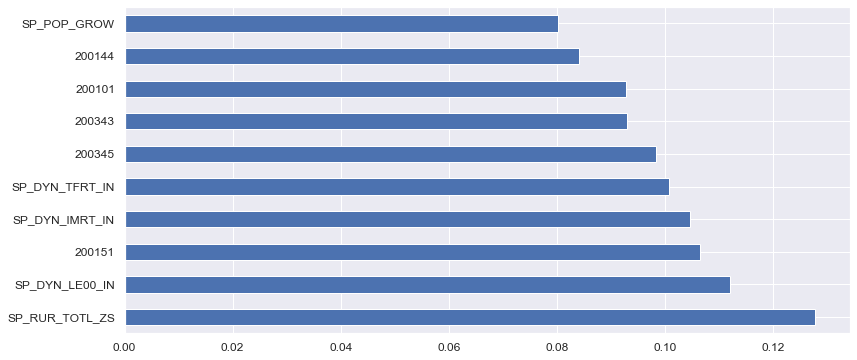

Correlation Matrix


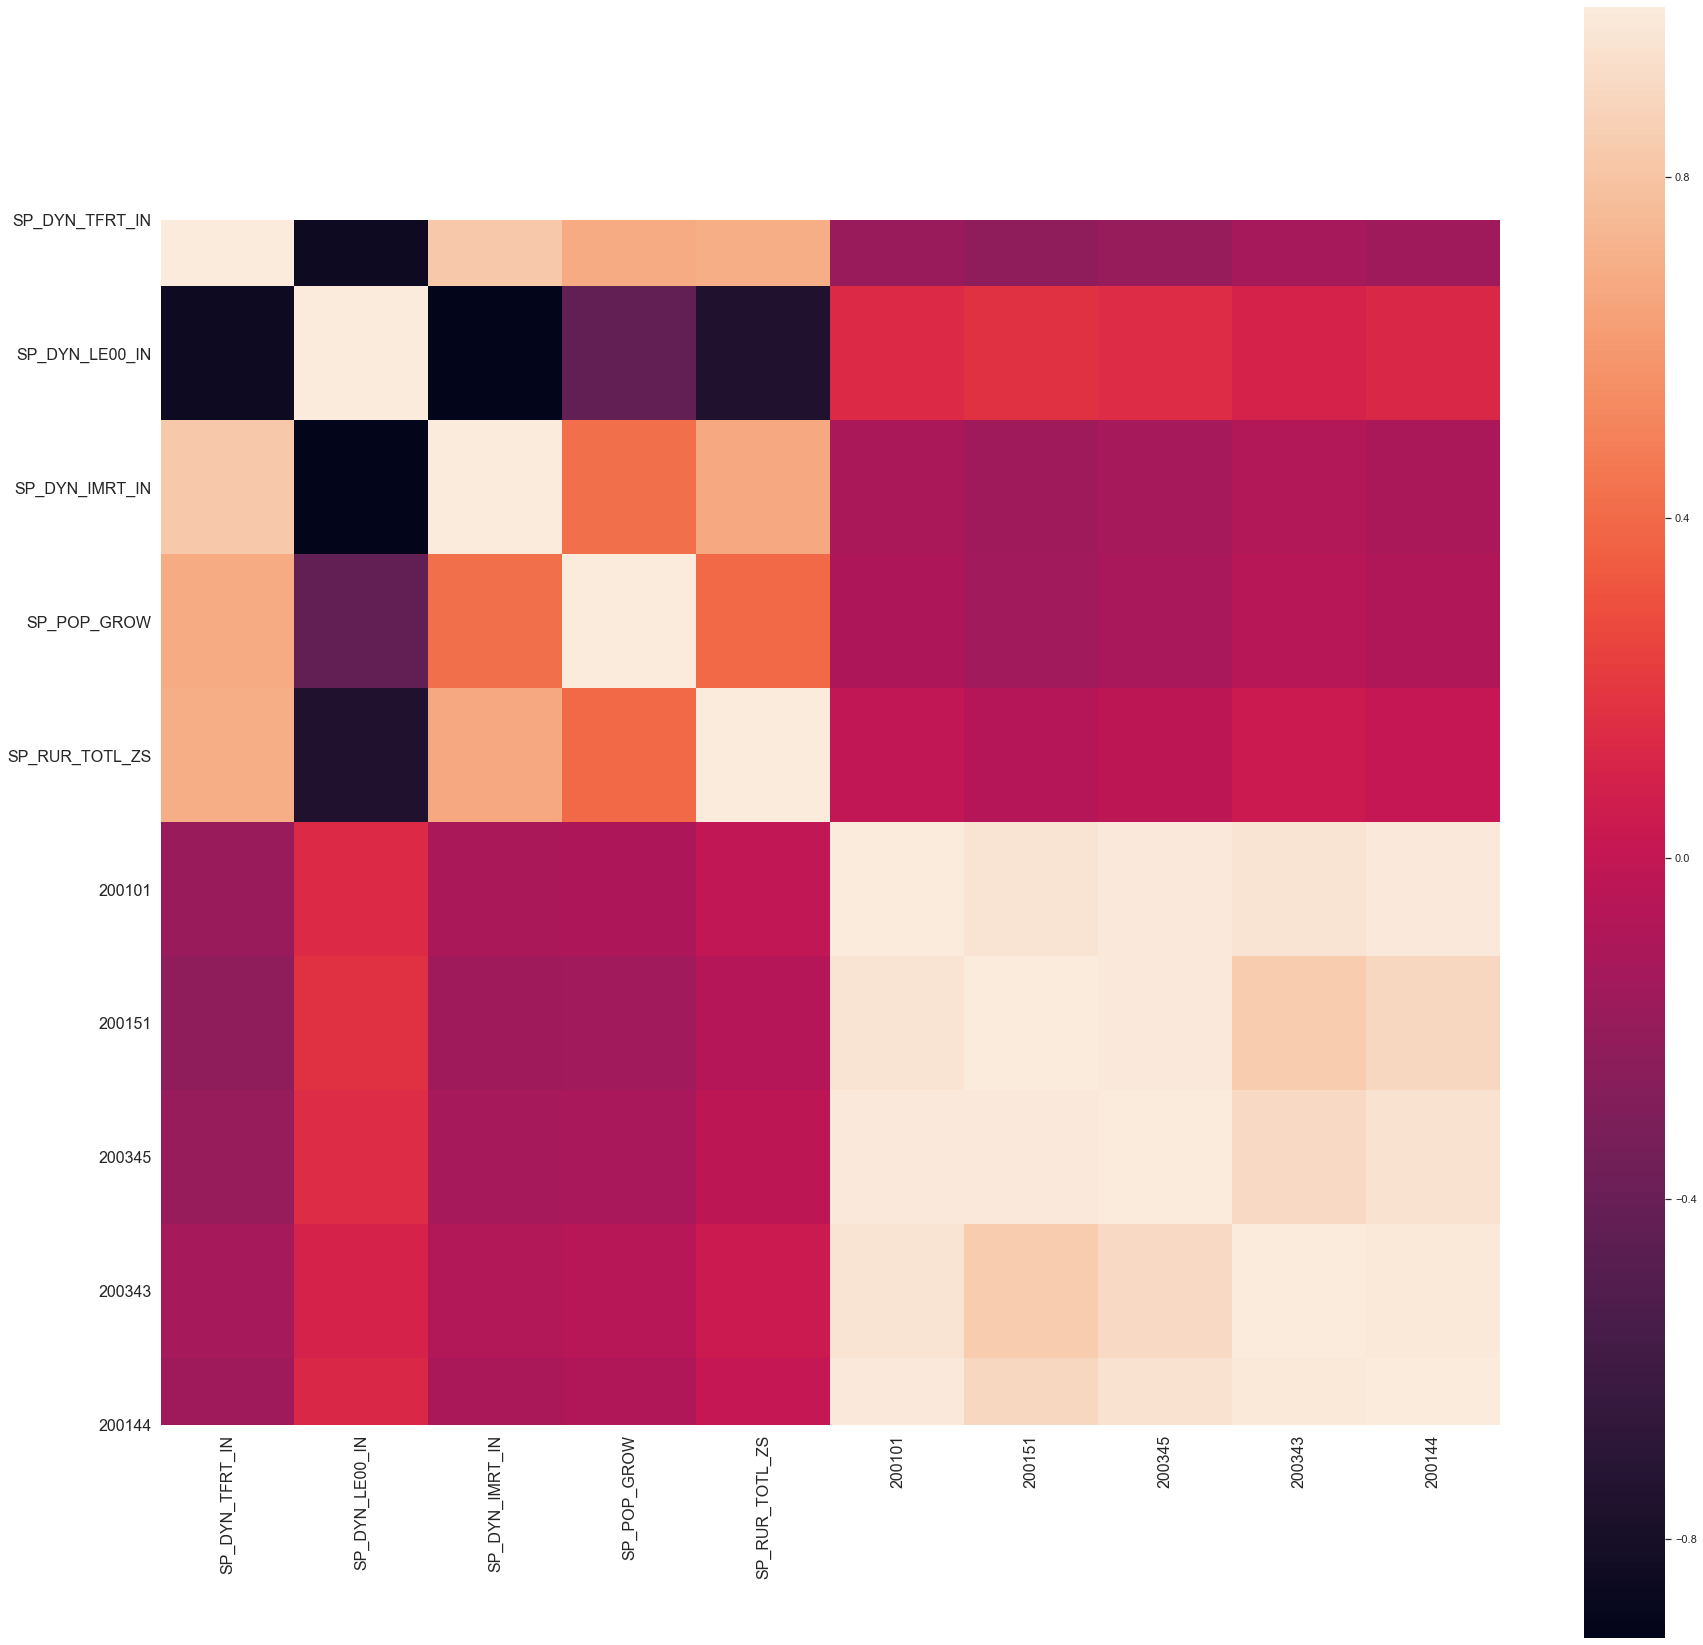

'All fertig pa pitura'

In [64]:
'''
st.write("Best ")
st.write("f_classif")
st.write(e_poor_selectKBest(e_poor,score_f=f_classif))
st.write("chi2")
st.write(e_poor_selectKBest(e_poor,score_f=chi2))
st.write("mutual_info_classif")
st.write(e_poor_selectKBest(e_poor,score_f=mutual_info_classif))
st.write("feature_importance")
e_poor_feature_importance(e_poor)
st.write("Correlation Matrix")
plot_correlation_matrix(e_poor)
'''

print("Execution of the K Best features")
print("f_classif")
print(e_poor_selectKBest(e_poor,score_f=f_classif))
#e_poor_selectKBest(e_poor,score_f=f_classif)

print("chi2")
print(e_poor_selectKBest(e_poor,score_f=chi2))
#e_poor_selectKBest(e_poor,score_f=chi2)
print("mutual_info_classif")
print(e_poor_selectKBest(e_poor,score_f=mutual_info_classif))
#e_poor_selectKBest(e_poor,score_f=mutual_info_classif)
print("feature_importance")
e_poor_feature_importance(e_poor)
print("Correlation Matrix")
plot_correlation_matrix(e_poor)


def e_poor_selectKBest(df_e_poor, score_f = f_classif, k='all'):
    e_poor = df_e_poor
    # Split dataset to train
    X = e_poor.iloc[:,2:-2] # All the columns less the last one
    y = e_poor.iloc[:,-2:-1] # Just the last column
    dfcolumns = pd.DataFrame(X.columns)

    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    # Create the feature selector
    # perhaps a switch
    bestFeatures = SelectKBest(score_func=score_f, k=k)
    fit = bestFeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)

    # Create a data frame to see the impact of the features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Features','Scores']
    featureScores.sort_values(by='Scores', ascending=False, inplace=True)
    
    return(featureScores)

# SHOW FEATURE IMPORTANCES
selectKBest_df = pd.merge(e_poor_selectKBest(e_poor), e_poor_selectKBest(e_poor,score_f=chi2), on='Features')
selectKBest_df.columns = ['Features', 'f-classif', 'chi2']
selectKBest_df

### Feature Importance with ExtraTreesClassifier

def e_poor_feature_importance(df_e_poor):
    e_poor = df_e_poor
    # Split dataset to train
    X = e_poor.iloc[:,2:-2] # All the columns less the last one
    y = e_poor.iloc[:,-2:-1] # Just the last column
    model = ExtraTreesClassifier()
    model.fit(X,y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(20).plot(kind='barh', figsize = (13, 6), fontsize=12)

e_poor_feature_importance(e_poor)

## Unifying Question 2 and Question 3

In [67]:
import plotly.graph_objects as go
# TRANSFORM DATA FOR BAR PLOT
Features = ['%Pop in Rural Areas', 'Population Growth', 'Fertility', 'Life Expectancy', 'Mortality Rate']
selectKBest_df['f-classif'] = np.abs(selectKBest_df['f-classif'])/np.abs(selectKBest_df['f-classif']).sum()
bar_emerge = selectKBest_df.sort_values(by='Features', ascending=False)['f-classif'].tolist()
bar_poverty = q2_weights[q2_weights.col != 'TIME'].sort_values(by='col', ascending=False)['relative'].to_list()

# PLOT
fig = go.Figure(data=[
    go.Bar(name='In Poverty', x=Features, y=bar_poverty),
    go.Bar(name='Emerged', x=Features, y=bar_emerge)
])
fig.update_layout(barmode='group')
fig.show()

# Conclusions